<a href="https://colab.research.google.com/github/agupta7654/ml-colab/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In this notebook we use an RNN network to classify text. The text we will use are IMDB movie reviews and the classification is either positive (1) or negative (0). We employ several different techniques from our other models
* The input lengths vary and there are no windows -- the input is the entire review. This will require the use of "padding" tokens to keep the data stored in a matrix
* The input words are encoded to integers using a tensorflow text vectorization layer.
* These vectors are embedded in a high dimensional vector space using an embedding layer
* We also show how to use a pretrained embedding layer in your model (requires access to kaggle)
* The model data is stored as a tensorflow dataset, which allows shuffling, batchig and caching to optimize training time.

In [ ]:
# Sentiment Analysis

In [ ]:
  import tensorflow_datasets as tfds
  import tensorflow as tf

Load the data from tensorflow's own database

In [ ]:
raw_train, raw_validation, raw_test = tfds.load(
    name="imdb_reviews",
    split=['train', 'test', 'test'],
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2D9IIF_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2D9IIF_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2D9IIF_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Create datasets that use shuffling, batching and prefetching. (Change the batchsize here if you want)

In [ ]:
tf.random.set_seed(42)
train_set = raw_train.shuffle(5000, seed=42).batch(128).prefetch(1)
valid_set = raw_validation.batch(128).prefetch(1)
test_set = raw_test.batch(128).prefetch(1)

Show some of the raw data. Notice the use of `take` to extract data from a tf.dataset

In [ ]:
for review, label in raw_train.take(10):
    print(review.numpy().decode("utf-8")) # decode converts a python byte array to correct text
    print(label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was co

Do some EDA on the dataset. Also note how we access and iterate through the raw data

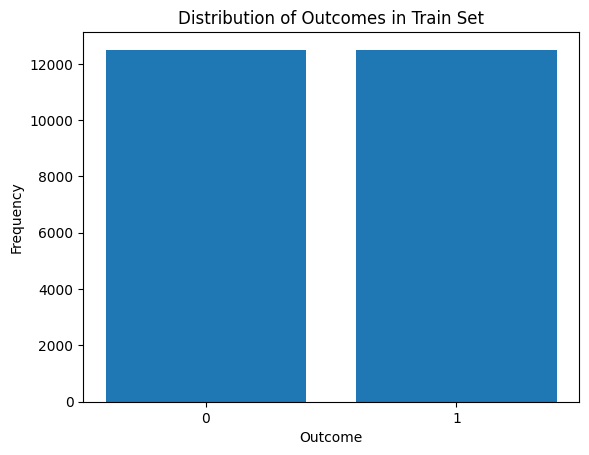

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'train_set' is a tf.data.Dataset with labels (0 or 1)
label_list = []
for _, label in raw_train:
  label_list.append(label.numpy())

plt.hist(label_list, bins=[0, 0.5, 1], rwidth=0.8)
plt.xlabel("Outcome")
plt.ylabel("Frequency")
plt.title("Distribution of Outcomes in Train Set")
plt.xticks([0.25, 0.75], ["0", "1"])
plt.show()


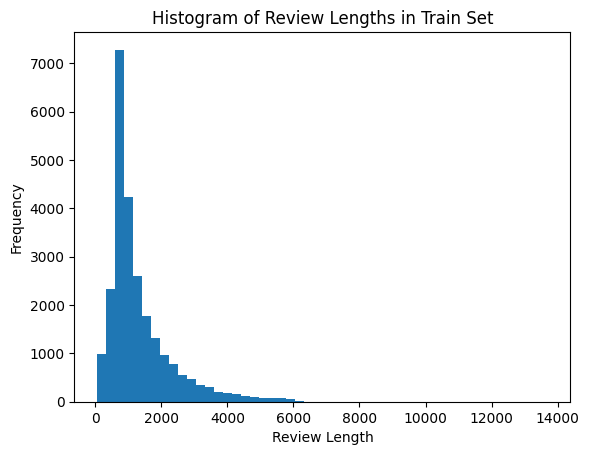

In [ ]:
review_lengths = []
for review, _ in raw_train:
  review_lengths.append(len(review.numpy()))

plt.hist(review_lengths, bins=50)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Histogram of Review Lengths in Train Set")
plt.show()


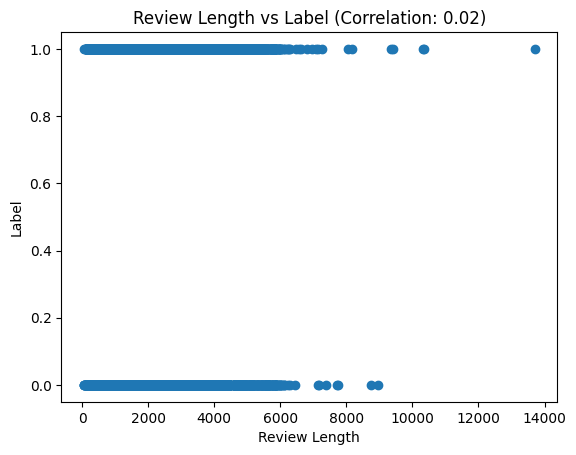

Correlation between review length and label: 0.02


In [ ]:
import numpy as np

review_lengths = []
labels = []
for review, label in raw_train:
  review_lengths.append(len(review.numpy()))
  labels.append(label.numpy())

# Calculate correlation
correlation = np.corrcoef(review_lengths, labels)[0, 1]

# Plot review length vs label
plt.scatter(review_lengths, labels)
plt.xlabel("Review Length")
plt.ylabel("Label")
plt.title(f"Review Length vs Label (Correlation: {correlation:.2f})")
plt.show()

print(f"Correlation between review length and label: {correlation:.2f}")


As we have done before using scikit-learn (or manual code), we convert the top 1000 most common vocab terms in the dataset to integers. We will use a tensorflow TextVectorization layer to do so. The layer will take some time to train because of the size of the data. Therefore we show how to save the layer as a tensorflow model for extraction later. Set the 'false' below to 'true' to generate the layer. Be sure to update the filepath and mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if True:
  vocab_size = 1000
  text_vec_layer = tf.keras.layers.TextVectorization(
      max_tokens=vocab_size,
      output_mode="int",
  )
  text_vec_layer.adapt(raw_train.map(lambda review, label: review))
    # Create model to save TextVectorization Layer
  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
  model.add(text_vec_layer)

  # Save.
  filepath = "/content/drive/MyDrive/Junior Research Project/Sentiment Analysis/TextVecLayer-IMBD.keras"
  model.save(filepath)

Now load the layer (from above or an earlier session)

In [ ]:
filepath = "/content/drive/MyDrive/Junior Research Project/Sentiment Analysis/TextVecLayer-IMBD.keras"
loaded_model = tf.keras.models.load_model(filepath)
text_vec_layer = loaded_model.layers[0]

Let's see how this layer works

In [ ]:
text_vec_layer.vocabulary_size()

1000

In [ ]:
text_vec_layer.get_vocabulary()[:20]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('and'),
 np.str_('a'),
 np.str_('of'),
 np.str_('to'),
 np.str_('is'),
 np.str_('in'),
 np.str_('it'),
 np.str_('i'),
 np.str_('this'),
 np.str_('that'),
 np.str_('br'),
 np.str_('was'),
 np.str_('as'),
 np.str_('for'),
 np.str_('with'),
 np.str_('movie'),
 np.str_('but')]

Token #1 is UNK, for unknown words (not in the top 1000 vocab). Token 0 is empty space used for padding.

In [ ]:
text_vec_layer(["you", 'saw', 'the', 'armadillo', '', ''])

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[ 23],
       [208],
       [  2],
       [  1],
       [  0],
       [  0]])>

Now create the model. Use the vector layer and an embedding layer. Then a simple GRU stack and a single neuron to classify. Note the use of sigmoid since the output data is a single [0,1] variable.

In [ ]:
import os, datetime

embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.5973 - loss: 0.6725 - val_accuracy: 0.7254 - val_loss: 0.5437
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8137 - loss: 0.4142 - val_accuracy: 0.8433 - val_loss: 0.3714
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8590 - loss: 0.3372 - val_accuracy: 0.8674 - val_loss: 0.3172
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.8777 - loss: 0.3025 - val_accuracy: 0.8715 - val_loss: 0.3049
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8894 - loss: 0.2760 - val_accuracy: 0.8625 - val_loss: 0.3503


+
### Task

*TO DO*. Run the model on some testing data and print a few of the samples it misclassifies. Read the samples yourself -- do you see why they were misclassified?

In [ ]:
import numpy as np

# Get true labels (y) for the entire test set
y_true = []
for batch in test_set:
    _, y_batch = batch  # Only take labels (ignore X with `_`)
    y_true.append(y_batch.numpy())  # Convert to NumPy
y_true = np.concatenate(y_true)  # Combine all batches into one array

# Get predictions from the model for the entire test set
classifications = model.predict(test_set)
classifications = (classifications > 0.5).astype(int)  # Convert predictions to binary values (0 or 1)
print(classifications)

# Calculate accuracy
accuracy = np.mean(classifications == y_true)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Identify misclassified instances
misclassified_indices = np.where(classifications != y_true)[0]  # Get indices of misclassifications

# Print some misclassified inputs
misclassified_X = []  # List to store misclassified inputs
for idx in misclassified_indices[:5]:  # Print up to 5 misclassified examples
    for batch in test_set.take(1):  # Get the first batch
        X_batch, _ = batch  # Get the input features (X)
        misclassified_X.append(X_batch[idx].numpy())  # Append the misclassified input (X)
        break

# Print some misclassified X values along with true labels and predictions
for i, idx in enumerate(misclassified_indices[:5]):
    print(f"Misclassified Sample {i+1}:")
    print(f"True Label: {y_true[idx]}")
    print(f"Predicted: {classifications[idx]}")
    print(f"Misclassified Input (X): {misclassified_X[i]}")
    print("-" * 50)


196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [1]]
Accuracy: 50.00%


# Pretrained Encoding Layers

We show how to load a pretrained sentence encoding layer. There were some complications here getting this to run so there are some hacky fixes. Also note the url hard-links to kaggle, so you need to access that to get the model. Currently this example does not get better accuracy than above in 5 epochs. Consider it a work in progress.

In any case, this model trained on millions of text documents encodes entire sentences into one vector.

In [ ]:
import os
import tensorflow_hub as hub

os.environ["TFHUB_CACHE_DIR"] = "/content/drive/MyDrive/Colab/Cache"

encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True, dtype=tf.string, input_shape=[])

In [ ]:
encoder_layer(["I don't think you enjoy the company of cats"])

In [ ]:
import os, datetime

embed_size = 128
tf.random.set_seed(42)
encoder_layer_wrapped = tf.keras.layers.Lambda(lambda x: encoder_layer(x))

model = tf.keras.Sequential([
    encoder_layer_wrapped,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])


tf.config.optimizer.set_jit(False)


history = model.fit(train_set, validation_data=valid_set, epochs=5, callbacks=[tensorboard_callback])

### Task

Classify another text corpus -- I suggest the Amazon Review dataset (ask Brian for details). This is a 1-5 rating so you will probably want to one-hot encode the classifications. You could re-use the TextVectorization layer above or train a new one. If you want you can also use a pretrained model and see how it does.

In [ ]:
### Your code here